In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
base_path = os.getcwd().split("it_core_project1")[0] + "it_core_project1"
sys.path.append(base_path)

from src.scripts.utils import set_path

['.ipynb_checkpoints',
 'deployment.ipynb',
 'task1_exp.ipynb',
 'task2.ipynb',
 'task3.ipynb',
 'task4 doc.txt',
 'task4.ipynb']

In [2]:
%matplotlib widget

# USER ENGAGEMENT ANALYSIS (TASK 2)

In the current dataset you’re expected to track the user’s engagement using the following engagement metrics: 
●	sessions frequency 
●	the duration of the session 
●	the sessions total traffic (download and upload (bytes))

Task 2.1 - Based on the above submit python script and slide :
●	Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 
●	Normalize each engagement metric and run a k-means (k=3) to classify customers into three groups of engagement. 
●	Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.
●	Aggregate user total traffic per application and derive the top 10 most engaged users per application
●	Plot the top 3 most used applications using appropriate charts.  
●	Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
○	What is the optimized value of k (use elbow method for this)?  
○	Interpret your findings.

In [3]:
path = set_path("data")


>> set up path to the data directory


In [4]:
def resolve_outlier_iqr(df):
    data = df.copy()
    for i in data.select_dtypes(["int", "float"]).keys():
        Q1,Q3 = data[i].quantile([.20,.80])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        lr_ind = data[i][data[i] < lower_range].keys()
        ur_ind = data[i][data[i] > upper_range].keys()

        data.loc[lr_ind, i] = np.nan
        data.loc[ur_ind, i] = np.nan
        data[i].fillna(data[i].mean(), inplace= True)
    return data

In [5]:
def resolve_outlier(df):
    ## using z-score, then iqr
    data = df.copy()
    for i in data.select_dtypes(["int", "float"]).keys():
        outliers = data[i][(abs((data[i] - data[i].mean()) / data[i].std()) > 3)].keys()
        data.loc[outliers, i] = np.nan
        data[i].fillna(data[i].mean(), inplace= True)
    ## iqr
    data = resolve_outlier_iqr(data)
    return data

In [6]:
aggregates = pd.read_csv(path + "aggregates.csv", index_col=["MSISDN"])

In [7]:
engagement = aggregates[["tot number of session", "tot sessions duration (hrs)", "tot data usage (MBs)"]]

In [8]:
top10_users_with_high_session_freq = (engagement["tot number of session"]
                                      .sort_values(ascending = False).to_frame()
                                      .head(10)
                                     )

top10_users_with_high_sessions_duration = (engagement["tot sessions duration (hrs)"]
                                      .sort_values(ascending = False).to_frame()
                                      .head(10)
                                     )

top10_users_with_high_data_usage = (engagement["tot data usage (MBs)"]
                                      .sort_values(ascending = False).to_frame()
                                      .head(10)
                                     )

In [9]:
top10_users_with_high_data_usage

,tot data usage (MBs)
MSISDN,
33650426463,4860.047088
33666169635,4550.902257
33665354456,4387.362709
33699904865,4270.838906
33665550456,4177.437149
33699382524,4070.142609
33763573482,4041.040859
33661622844,4017.970123
33658849197,3979.991702


In [10]:
scaler = MinMaxScaler()

In [11]:
agg_scaled = pd.DataFrame(scaler.fit_transform(resolve_outlier(aggregates)), columns= aggregates.columns)

In [12]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [13]:
kmeans.fit(agg_scaled)

KMeans(n_clusters=3, random_state=0)

In [14]:
agg_plus_cluster = aggregates.copy()
agg_plus_cluster["labels"] = kmeans.labels_

In [15]:
task2_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns = aggregates.columns)

In [16]:
mapper = dict(zip(task2_cluster_centers["tot data usage (MBs)"].sort_values().keys(), ["less engagement", "medium engagement", "much engagement"]))

In [17]:
task2_cluster_centers = task2_cluster_centers.rename(index = mapper).rename_axis("labels")
task2_cluster_centers.to_csv(path + "user_engagement_cluster_centers.csv")

In [18]:
agg_plus_cluster["labels"] = agg_plus_cluster["labels"].map(mapper)

### Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [19]:
agg_plus_cluster.groupby("labels").mean().T.style

labels,less engagement,medium engagement,much engagement
tot number of session,1.006169,1.143942,2.275222
tot sessions duration (hrs),28.643424,33.271918,62.364477
social media data usage (MBs),1.741781,2.003693,3.972197
google data usage (MBs),7.434825,8.571129,16.936597
Email data usage (MBs),2.162402,2.478249,4.887854
youtube data usage (MBs),21.585511,24.865649,49.073259
netflix data usage (MBs),21.550335,24.765109,49.204858
gaming apps data usage (MBs),209.304470,665.690679,931.323524
other apps data usage (MBs),410.194389,470.607694,931.299281
tot downloaded data (MBs),232.423783,692.412324,984.042207


In [20]:
agg_plus_cluster.groupby("labels").max().T.style

labels,less engagement,medium engagement,much engagement
tot number of session,2.000000,11.000000,6.000000
tot sessions duration (hrs),327.088056,359.504444,353.680556
social media data usage (MBs),6.783621,22.698244,14.190845
google data usage (MBs),27.493017,83.574781,50.450966
Email data usage (MBs),8.075029,21.861470,17.333397
youtube data usage (MBs),71.286839,237.480580,158.641153
netflix data usage (MBs),66.785300,222.896995,148.620392
gaming apps data usage (MBs),441.201642,4343.421737,3060.295975
other apps data usage (MBs),1478.810741,4392.022408,3115.962507
tot downloaded data (MBs),453.979897,4545.041459,3161.623498


In [21]:
agg_plus_cluster.groupby("labels").mean().T.style

labels,less engagement,medium engagement,much engagement
tot number of session,1.006169,1.143942,2.275222
tot sessions duration (hrs),28.643424,33.271918,62.364477
social media data usage (MBs),1.741781,2.003693,3.972197
google data usage (MBs),7.434825,8.571129,16.936597
Email data usage (MBs),2.162402,2.478249,4.887854
youtube data usage (MBs),21.585511,24.865649,49.073259
netflix data usage (MBs),21.550335,24.765109,49.204858
gaming apps data usage (MBs),209.304470,665.690679,931.323524
other apps data usage (MBs),410.194389,470.607694,931.299281
tot downloaded data (MBs),232.423783,692.412324,984.042207


In [22]:
agg_plus_cluster.groupby("labels").count().T.iloc[0]

labels
less engagement      38907
medium engagement    40676
much engagement      26971
Name: tot number of session, dtype: int64

In [23]:
agg_plus_cluster.to_csv(path + "user_engagement_data.csv")

''

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
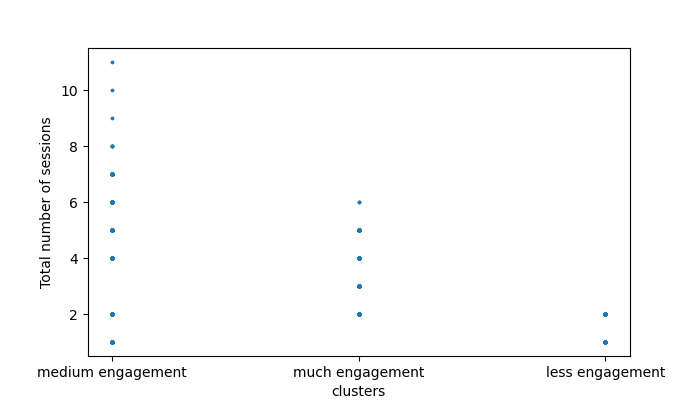

In [24]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.scatter(agg_plus_cluster["labels"], agg_plus_cluster["tot number of session"], s=3)
plt.xlabel("clusters")
plt.ylabel("Total number of sessions");

###  ● Aggregate user total traffic per application and derive the top 10 most engaged users per application ● Plot the top 3 most used applications using appropriate charts.

In [25]:
app_cols = ['social media data usage (MBs)', 'google data usage (MBs)',
       'Email data usage (MBs)', 'youtube data usage (MBs)',
       'netflix data usage (MBs)', 'gaming apps data usage (MBs)',
       ]
largest_10_entries_per_metric = pd.DataFrame()
for i in app_cols:
    largest_10_entries_per_metric[i] = aggregates[i].sort_values(ascending= False).head(10).tolist()

In [26]:
largest_10_entries_per_metric

,social media data usage (MBs),google data usage (MBs),Email data usage (MBs),youtube data usage (MBs),netflix data usage (MBs),gaming apps data usage (MBs)
0,22.698244,83.574781,21.861470,237.480580,222.896995,4343.421737
1,18.186049,75.072834,20.907565,226.046673,202.187567,4050.096912
2,17.218717,74.219402,20.026962,225.451283,197.875129,3993.737237
3,17.149566,68.766560,19.655470,191.224544,195.816385,3919.795651
4,15.816863,68.640566,19.284823,183.959473,192.058394,3790.729834
5,15.753781,66.362096,18.671650,181.911520,190.238172,3647.933038
6,15.429578,66.128575,18.587090,180.657377,186.781820,3603.136848
7,15.359530,64.254685,18.344635,179.941454,184.438187,3571.500108
8,15.227897,62.406015,18.168324,179.292764,184.264451,3561.990721
9,14.992252,62.305976,17.984228,178.700468,181.814404,3540.684531


### ● Plot the top 3 most used applications using appropriate charts.

we assume that the total amount of data used is prortional to how much the app is used. This may not be totally accurate but that's the best we can deduce from this data

In [27]:
top3_most_used_apps = aggregates[app_cols].sum().sort_values(ascending=False).head(3)

In [28]:
# convert MB to GB
top3_most_used_apps = top3_most_used_apps/1024 

In [29]:
top3_most_used_apps.columns = ["gaming apps data usage (GBs)", "youtube data usage (GBs)", "netflix data usage (GBs)"]

Text(0, 0.5, 'App total data usage (GBs)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
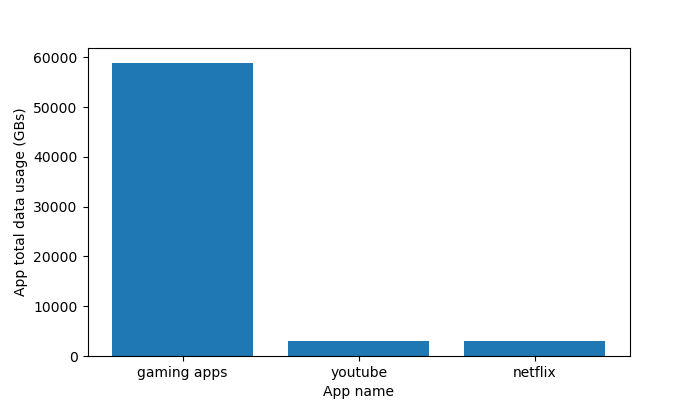

In [30]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,4))
ax2.bar([i.split(" data")[0] for i in top3_most_used_apps.columns], top3_most_used_apps)
plt.xlabel("App name")
plt.ylabel("App total data usage (GBs)")

In [31]:
%matplotlib inline

### Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: ○ What is the optimized value of k (use elbow method for this)?

In [32]:
kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(agg_scaled)
    sse.append(kmeans.inertia_)

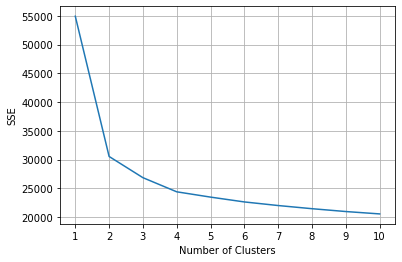

In [33]:
# plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(True)
#plt.show()

### ○ Interpret your findings.